<a href="https://colab.research.google.com/github/zeroistwo/deeplearning/blob/master/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI502/KSE527, Homework 02

In [0]:
!pip install ptflops

  Created wheel for ptflops: filename=ptflops-0.6.1-cp36-none-any.whl size=8513 sha256=140114ecbe1c7c0adf2bf1ccfb6ae509d466e1cce18ab00cc19c632eb02903c8
  Stored in directory: /root/.cache/pip/wheels/72/9d/42/7047ed6168fbc3d1d3794f2119a7ba032e28df06a5c6db5ea2
Successfully built ptflops


In [0]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torchvision.models as models

from torchsummary import summary
from tqdm.auto import tqdm

from ptflops import get_model_complexity_info 
## Reference of ptflops: https://github.com/sovrasov/flops-counter.pytorch

# CIFAR100

In [0]:
# Global Variable For training
# You just use the following hyper-parameters
BATCH_SIZE = 128
NUM_EPOCH = 100
LEARNING_RATE = 0.01
CRITERION = nn.CrossEntropyLoss()

In [0]:
# CIFAR10 Dataset
train_dataset = dsets.CIFAR100(root='./data', train=True, 
                              transform=transforms.Compose([
                                            transforms.RandomCrop(32, padding=4),
                                            transforms.RandomHorizontalFlip(),
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                                        ]), download=True)
test_dataset = dsets.CIFAR100(root='./data', train=False,
                             transform=transforms.Compose([
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                                        ]))
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Extracting ./data/cifar-100-python.tar.gz to ./data


# Fit / Eval function

In [0]:
def fit(model,train_loader):
    model.train()
    device = next(model.parameters()).device.index
    optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
    losses = []
    for i, data in enumerate(train_loader):
        image = data[0].type(torch.FloatTensor).cuda(device)
        label = data[1].type(torch.LongTensor).cuda(device)

        pred_label = model(image)
        loss = CRITERION(pred_label, label)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    avg_loss = sum(losses)/len(losses)
    return avg_loss

In [0]:
def eval(model, test_loader):
    model.eval()
    device = next(model.parameters()).device.index
    pred_labels = []
    real_labels = []

    for i, data in enumerate(test_loader):
        image = data[0].type(torch.FloatTensor).cuda(device)
        label = data[1].type(torch.LongTensor).cuda(device)
        real_labels += list(label.cpu().detach().numpy())
        
        pred_label = model(image)
        pred_label = list(pred_label.cpu().detach().numpy())
        pred_labels += pred_label
        
    real_labels = np.array(real_labels)
    pred_labels = np.array(pred_labels)
    pred_labels = pred_labels.argmax(axis=1)
    acc = sum(real_labels==pred_labels)/len(real_labels)*100
    
    return acc

### Model

In [0]:
plainnet_model = Net18(PlainBlock, [2, 2, 2, 2], 100).cuda()

In [0]:
pm_losses = []
pm_accuracy = []
for epoch in tqdm(range(NUM_EPOCH)):
    pm_loss = fit(plainnet_model, train_loader)
    pm_losses.append(pm_loss)
    pm_acc = eval(plainnet_model, test_loader)
    pm_accuracy.append(pm_acc)
    
    if (epoch + 1) % 10 == 0:
        print("{} epoch - loss : {}, accuracy : {}".format(epoch + 1, pm_loss, pm_acc))

10 epoch - loss : 1.3325507181989567, accuracy : 54.94
20 epoch - loss : 0.6935366602504954, accuracy : 61.870000000000005
30 epoch - loss : 0.3508738261049666, accuracy : 65.3
40 epoch - loss : 0.16247554037653272, accuracy : 68.07
50 epoch - loss : 0.09343183193060443, accuracy : 68.01
60 epoch - loss : 0.04835100974077764, accuracy : 69.19999999999999
70 epoch - loss : 0.033047395565396986, accuracy : 69.57
80 epoch - loss : 0.021740435906078503, accuracy : 71.1
90 epoch - loss : 0.01820388250291119, accuracy : 71.12
100 epoch - loss : 0.012182638732730733, accuracy : 70.78



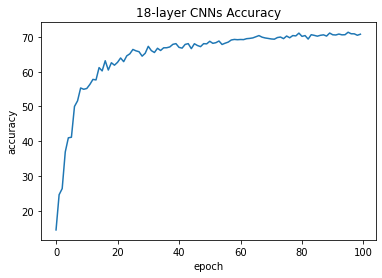

In [0]:
import matplotlib.pyplot as plt
plt.plot(pm_accuracy)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('18-layer CNNs Accuracy')
plt.show()

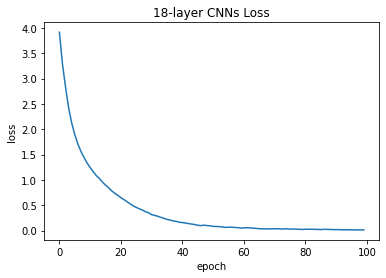

In [0]:
import matplotlib.pyplot as plt
plt.plot(pm_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('18-layer CNNs Loss')
plt.show()

In [0]:
resnet_model = Net18(ResidualBlock, [2, 2, 2, 2], 100).cuda()

In [0]:
rm_losses = []
rm_accuracy = []
for epoch in tqdm(range(NUM_EPOCH)):
    rm_loss = fit(resnet_model, train_loader)
    rm_losses.append(rm_loss)
    rm_acc = eval(resnet_model, test_loader)
    rm_accuracy.append(rm_acc)
    
    if (epoch + 1) % 10 == 0:
        print("{} epoch - loss : {}, accuracy : {}".format(epoch + 1, rm_loss, rm_acc))

10 epoch - loss : 1.1606078507650235, accuracy : 59.21999999999999
20 epoch - loss : 0.5627557553751085, accuracy : 65.42999999999999
30 epoch - loss : 0.24849126059228502, accuracy : 67.62
40 epoch - loss : 0.10355118130479017, accuracy : 69.35
50 epoch - loss : 0.05760208765983277, accuracy : 70.74000000000001
60 epoch - loss : 0.024941993796307106, accuracy : 71.36
70 epoch - loss : 0.017817541459084624, accuracy : 71.5
80 epoch - loss : 0.010812214973485073, accuracy : 71.85000000000001
90 epoch - loss : 0.008499688005594112, accuracy : 72.04
100 epoch - loss : 0.005813255349633849, accuracy : 72.72



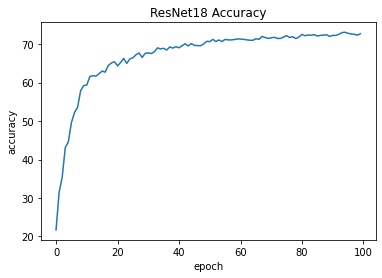

In [0]:
import matplotlib.pyplot as plt
plt.plot(rm_accuracy)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('ResNet18 Accuracy')
plt.show()

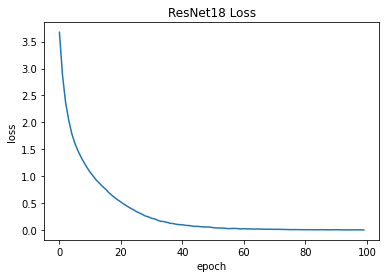

In [0]:
import matplotlib.pyplot as plt
plt.plot(rm_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('ResNet18 Loss')
plt.show()

In [0]:
mobilenet_model = Net18(MobileBlock, [2, 2, 2, 2], 100).cuda()

In [0]:
mm_losses = []
mm_accuracy = []
for epoch in tqdm(range(NUM_EPOCH)):
    mm_loss = fit(mobilenet_model, train_loader)
    mm_losses.append(mm_loss)
    mm_acc = eval(mobilenet_model, test_loader)
    mm_accuracy.append(mm_acc)
    
    if (epoch + 1) % 10 == 0:
        print("{} epoch - loss : {}, accuracy : {}".format(epoch + 1, mm_loss, mm_acc))

10 epoch - loss : 1.8143207956762875, accuracy : 38.83
20 epoch - loss : 1.1881058121581212, accuracy : 60.58
30 epoch - loss : 0.854404065919959, accuracy : 62.980000000000004
40 epoch - loss : 0.6206308421881302, accuracy : 63.78
50 epoch - loss : 0.4548903955218127, accuracy : 63.839999999999996
60 epoch - loss : 0.3247573199250814, accuracy : 64.92999999999999
70 epoch - loss : 0.2399588023000361, accuracy : 64.91
80 epoch - loss : 0.181412713702225, accuracy : 65.03999999999999
90 epoch - loss : 0.13827670018767457, accuracy : 65.42999999999999
100 epoch - loss : 0.10852557591274571, accuracy : 65.34



# Construct the 18 layers network

All of PlainNet18, ResNet18, MobileNet18 have same network structure but they are consist of different convolution block (PlainBlock, ResidualBlock, MobileBlock). You have to utilize Net18() when you define the network.

In [0]:
class Net18(nn.Module):
    def __init__(self, block, num_blocks, num_classes):
        super(Net18, self).__init__()
        self.inp = 64
        self.conv0 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn0 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, oup, num_block, stride=1):
        layers = []
        strides = [stride] + [1]*(num_block-1)
        for stride in strides:
            layers.append(block(self.inp, oup, stride))
            self.inp = oup
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.relu(self.bn0(self.conv0(x)))
        out = self.layer1(out)
        out = self.layer2(out) 
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

# Task1 : Implement 18-layer CNNs for CIFAR100

In [0]:
class PlainBlock(nn.Module):
    def __init__(self, inp, oup, stride=1):
        super(PlainBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(inp, oup, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=oup)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(oup, oup, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(num_features=oup)
        
    def forward(self, x):

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        return out

# Task2 : Implement ResNet18 for CIFAR100

In [0]:
class ResidualBlock(nn.Module):
	expansion = 1

	def __init__(self, inp, oup, stride=1):
		super(ResidualBlock, self).__init__()
		self.stride = stride
		self.conv1 = nn.Conv2d(inp, oup, kernel_size=3, stride=stride, padding=1, bias=False) 
		self.bn1 = nn.BatchNorm2d(oup)
		self.relu = nn.ReLU(inplace=True)
   		
		self.conv2 = nn.Conv2d(oup, oup, kernel_size=3, stride=1, padding=1, bias=False) 
		self.bn2 = nn.BatchNorm2d(oup)
		
		self.shortcut = nn.Sequential()
		if self.stride != 1 or inp != self.expansion * oup:
			self.shortcut = nn.Sequential(
				  nn.Conv2d(inp, self.expansion*oup, kernel_size=1, stride=stride, bias=True),
				  nn.BatchNorm2d(self.expansion*oup)
			)

	def forward(self, x):

		out = self.conv1(x)
		out = self.bn1(out)
		out = self.relu(out)
  
		out = self.conv2(out)
		out = self.bn2(out)

		out += self.shortcut(x)

		out = self.relu(out)
  
		return out

# Task3 : Implement MobileNet for CIFAR100

In [0]:
class MobileBlock(nn.Module):
    def __init__(self, inp, oup, stride=1):
        super(MobileBlock, self).__init__()
        
        def conv_dw(inp, oup, stride):
            return nn.Sequential(
                # dw
                nn.Conv2d(inp, oup, kernel_size=3, stride=stride, padding=1, groups=inp),
                nn.BatchNorm2d(oup),
                nn.ReLU(True),

                # pw
                nn.Conv2d(oup, oup, kernel_size=1, stride=1, padding=0),
                nn.BatchNorm2d(oup),
                nn.ReLU(True),
                )
        
        self.model = conv_dw(inp, oup, stride=stride)

    def forward(self, x):
        out = self.model(x)
        
        return out

### Model Complexity

In [0]:
# FLOPS

with torch.cuda.device(0):
    net = plainnet_model
    macs, params = get_model_complexity_info(net, (3, 32, 32), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
    print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
    print('{:<30}  {:<8}'.format('Number of parameters: ', params))

In [0]:
# FLOPS

with torch.cuda.device(0):
    net = mobilenet_model
    macs, params = get_model_complexity_info(net, (3, 32, 32), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
    print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
    print('{:<30}  {:<8}'.format('Number of parameters: ', params))